In [ ]:
import pickle
import numpy as np
import plotly.graph_objects as go

# Load the voxel data
with open("/kaggle/input/voxels/voxel/pdb111d_voxel.pkl", "rb") as f:
    voxel_data = pickle.load(f)

# Get non-zero voxel positions
voxel_presence = np.sum(voxel_data, axis=-1) > 0
x, y, z = np.where(voxel_presence)

# Create 3D scatter plot
fig = go.Figure(data=go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=z,
        colorscale='Viridis',
        opacity=0.8
    )
))

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='3D Voxel Visualization (Non-zero Voxels)',
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()


In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import argparse
import time
from google.colab import drive

# --- CONFIGURATION ---
parser = argparse.ArgumentParser(description="Enhanced Feature Extraction for Protein Structures")
parser.add_argument("--csv_file", default="pdb_voxel_mapping.csv", type=str, help="CSV file mapping voxels to descriptions")
parser.add_argument("--voxel_folder", default="voxel/voxel", type=str, help="Folder containing voxel grid files")
parser.add_argument("--output_folder", default="./extracted_features/", type=str, help="Output folder for extracted features")
parser.add_argument("--batch_size", default=8, type=int, help="Batch size for training and feature extraction")
parser.add_argument("--num_workers", default=2, type=int, help="Number of workers for data loading")
parser.add_argument("--pretrain", action="store_true", help="Pretrain the model on a classification task")
parser.add_argument("--pretrain_epochs", default=5, type=int, help="Number of epochs for pretraining")
parser.add_argument("--feature_dim", default=512, type=int, help="Dimension of extracted features")
parser.add_argument("--save_model", default="model_checkpoint.pth", type=str, help="Path to save model checkpoint")
parser.add_argument("--run_all", action="store_true", help="Run all architectures", default=True)

args = parser.parse_args([])  # Empty list for Google Colab

# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab environment")
    # Mount Google Drive if not already mounted
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
except:
    IN_COLAB = False
    print("Not running in Google Colab environment")

# Define configurations for each architecture
ARCHITECTURES = [
    {"name": "resnet18", "use_attention": False},
    {"name": "resnet18", "use_attention": True},
    {"name": "resnet34", "use_attention": False},
    {"name": "resnet34", "use_attention": True},
    {"name": "resnet50", "use_attention": False},
    {"name": "vit", "use_attention": False}  # ViT doesn't use conventional attention flag
]

# Make sure output folder exists
base_output_folder = args.output_folder
os.makedirs(base_output_folder, exist_ok=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- DATASET ---
class VoxelDataset(Dataset):
    def __init__(self, csv_file, voxel_folder, classification=False):
        """
        Args:
            csv_file (str): Path to the csv file with voxel file paths and descriptions
            voxel_folder (str): Directory with all the voxel files
            classification (bool): If True, prepare data for classification task
        """
        self.df = pd.read_csv(csv_file)
        self.voxel_folder = voxel_folder
        self.classification = classification

        # For classification pretraining, we'll create pseudo-labels based on structural features
        if classification:
            # This is a simplification - in reality, you might want to cluster proteins or use real labels
            # Here we're just using position in the dataset as a proxy for classes (for demonstration)
            num_classes = min(len(self.df), 10)  # Limit to 10 classes for simplicity
            self.df['class_label'] = self.df.index % num_classes

        # Determine voxel file column
        if "Voxel File" in self.df.columns:
            self.voxel_column = "Voxel File"
        elif "voxel_file" in self.df.columns:
            self.voxel_column = "voxel_file"
        else:
            self.voxel_column = self.df.columns[0]  # Assume first column contains voxel file paths

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        voxel_file = row[self.voxel_column]
        voxel_path = os.path.join(self.voxel_folder, voxel_file)

        if not os.path.exists(voxel_path):
            print(f"⚠️ Warning: File not found - {voxel_path}")
            voxel_grid = np.zeros((1, 64, 64, 64), dtype=np.float32)
        else:
            try:
                with open(voxel_path, "rb") as f:
                    voxel_grid = pickle.load(f)
                voxel_grid = np.array(voxel_grid, dtype=np.float32)

                # Handle different voxel formats
                if voxel_grid.ndim == 4:
                    # Some voxels might have channels dimension
                    voxel_grid = voxel_grid[..., 0]

                # Add channel dimension if needed
                if voxel_grid.ndim == 3:
                    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # (1, 64, 64, 64)
            except Exception as e:
                print(f"❌ Error loading {voxel_path}: {e}")
                voxel_grid = np.zeros((1, 64, 64, 64), dtype=np.float32)

        # Convert to tensor
        voxel_tensor = torch.tensor(voxel_grid, dtype=torch.float32)

        if self.classification:
            class_label = row['class_label']
            return voxel_tensor, class_label, voxel_file
        else:
            return voxel_tensor, voxel_file


# --- ATTENTION MODULE ---
class SpatialAttention3D(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv3d(in_channels // 8, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Channel attention first
        attention = F.avg_pool3d(x, x.size()[2:])  # Global average pooling
        attention = self.conv1(x)
        attention = F.relu(attention)
        attention = self.conv2(attention)
        attention_map = self.sigmoid(attention)

        # Apply attention
        return x * attention_map


# --- RESIDUAL BLOCK ---
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_attention=False):
        super(ResidualBlock, self).__init__()
        self.use_attention = use_attention

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        if self.use_attention:
            self.attention = SpatialAttention3D(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.use_attention:
            out = self.attention(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out


# --- RESNET MODEL ---
class ResNet3D(nn.Module):
    def __init__(self, block_counts, input_shape=(1, 64, 64, 64), feature_dim=512, num_classes=10, use_attention=False):
        super(ResNet3D, self).__init__()
        self.in_channels = 64
        self.use_attention = use_attention
        self.feature_dim = feature_dim

        # Initial convolution
        self.conv1 = nn.Conv3d(input_shape[0], 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(64, block_counts[0], stride=1)
        self.layer2 = self._make_layer(128, block_counts[1], stride=2)
        self.layer3 = self._make_layer(256, block_counts[2], stride=2)
        self.layer4 = self._make_layer(512, block_counts[3], stride=2)

        # Global average pooling and final FC layer
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc_features = nn.Linear(512, feature_dim)
        self.fc_classifier = nn.Linear(feature_dim, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride, self.use_attention))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # Feature extraction
        features = self.forward_features(x)

        # Classification head
        x = self.fc_classifier(features)
        return x, features

    def forward_features(self, x):
        # Feature extraction without final classification
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_features(x)
        return x


# --- VISION TRANSFORMER FOR 3D ---
class PatchEmbed3D(nn.Module):
    """Convert 3D volume into patches and embed them"""
    def __init__(self, vol_size=64, patch_size=8, in_chans=1, embed_dim=768):
        super().__init__()
        self.vol_size = vol_size
        self.patch_size = patch_size
        num_patches = (vol_size // patch_size) ** 3
        self.num_patches = num_patches

        self.proj = nn.Conv3d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W, D = x.shape
        assert H == W == D == self.vol_size, "Input volume size doesn't match"

        # (B, C, H, W, D) -> (B, embed_dim, H/patch_size, W/patch_size, D/patch_size)
        x = self.proj(x)
        # Reshape to (B, num_patches, embed_dim)
        x = x.flatten(2).transpose(1, 2)
        return x


class Attention(nn.Module):
    """Multi-head self-attention"""
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MLP(nn.Module):
    """MLP block in Transformer"""
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class TransformerBlock(nn.Module):
    """Transformer block with attention and MLP"""
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class VisionTransformer3D(nn.Module):
    """Vision Transformer for 3D volumes"""
    def __init__(self, vol_size=64, patch_size=8, in_chans=1, num_classes=10, embed_dim=768,
                 depth=12, num_heads=12, mlp_ratio=4., qkv_bias=True, drop_rate=0.1, feature_dim=512):
        super().__init__()
        self.patch_embed = PatchEmbed3D(vol_size=vol_size, patch_size=patch_size,
                                      in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        # Add cls token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Position embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio,
                           qkv_bias=qkv_bias, drop=drop_rate, attn_drop=drop_rate)
            for i in range(depth)
        ])

        self.norm = nn.LayerNorm(embed_dim)

        # Features and classification heads
        self.fc_features = nn.Linear(embed_dim, feature_dim)
        self.fc_classifier = nn.Linear(feature_dim, num_classes)

        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        # Patch embedding
        x = self.patch_embed(x)

        # Add cls token
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Add position embedding
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        # Apply normalization
        x = self.norm(x)

        # Use [CLS] token for features
        x = x[:, 0]
        x = self.fc_features(x)
        return x

    def forward(self, x):
        features = self.forward_features(x)
        x = self.fc_classifier(features)
        return x, features


# --- MODEL FACTORY ---
def create_model(model_type, feature_dim=512, num_classes=10, use_attention=False):
    """Create a model based on the model_type parameter"""
    if model_type == "resnet18":
        return ResNet3D([2, 2, 2, 2], feature_dim=feature_dim, num_classes=num_classes, use_attention=use_attention)
    elif model_type == "resnet34":
        return ResNet3D([3, 4, 6, 3], feature_dim=feature_dim, num_classes=num_classes, use_attention=use_attention)
    elif model_type == "resnet50":
        return ResNet3D([3, 4, 6, 3], feature_dim=feature_dim, num_classes=num_classes, use_attention=use_attention)
    elif model_type == "vit":
        # Smaller ViT for Google Colab to avoid OOM issues
        return VisionTransformer3D(vol_size=64, patch_size=8, in_chans=1, num_classes=num_classes,
                                 embed_dim=384, depth=6, num_heads=6, feature_dim=feature_dim, drop_rate=0.1)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")


# --- PRETRAIN FUNCTION (SIMPLIFIED FOR COLAB) ---
def pretrain_model(model, train_loader, val_loader, num_epochs=5, device="cuda"):
    """Pretrain the model on a classification task (simplified for Colab)"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for voxels, labels, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            voxels, labels = voxels.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(voxels)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for voxels, labels, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                voxels, labels = voxels.to(device), labels.to(device)

                outputs, _ = model(voxels)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * correct / total

        # Print status
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return model


# --- FEATURE EXTRACTION FUNCTION ---
def extract_features(model, dataloader, output_folder):
    """Extract features from the model and save them to the output folder"""
    model.eval()
    start_time = time.time()

    with torch.no_grad():
        for voxels, filenames in tqdm(dataloader, desc="Extracting Features"):
            voxels = voxels.to(device)

            # For classification dataset
            if isinstance(filenames, tuple) and len(filenames) == 2:
                _, filenames = filenames

            # Extract features
            if isinstance(model, VisionTransformer3D):
                features = model.forward_features(voxels)
            else:
                features = model.forward_features(voxels)

            # Save features for each sample
            for i, filename in enumerate(filenames):
                # Remove file extension and replace with .npy
                base_name = os.path.splitext(os.path.basename(filename))[0]
                feature_path = os.path.join(output_folder, f"{base_name}.npy")
                np.save(feature_path, features[i].cpu().numpy())

    extraction_time = time.time() - start_time
    print(f"✅ Features extracted in {extraction_time:.2f}s and saved to {output_folder}")


# --- FEATURE ANALYSIS FUNCTION ---
def analyze_features(output_folder, architecture_name, use_attention=False, n_samples=10):
    """Analyze the extracted features to check their quality"""
    print(f"\nAnalyzing extracted features for {architecture_name} (attention={use_attention})...")
    feature_files = os.listdir(output_folder)

    if len(feature_files) == 0:
        print("No feature files found!")
        return

    # Load a sample of feature files
    sample_files = np.random.choice(feature_files, min(n_samples, len(feature_files)), replace=False)
    features = []

    for file in sample_files:
        feature_path = os.path.join(output_folder, file)
        feature = np.load(feature_path)
        features.append(feature)

    features = np.array(features)

    # Print some statistics
    print(f"Feature shape: {features[0].shape}")
    print(f"Feature mean: {np.mean(features):.4f}")
    print(f"Feature std: {np.std(features):.4f}")
    print(f"Feature min: {np.min(features):.4f}")
    print(f"Feature max: {np.max(features):.4f}")

    # Plot feature distribution
    plt.figure(figsize=(10, 6))
    plt.hist(features.flatten(), bins=50)
    plt.title(f"Feature Distribution - {architecture_name} (Attention={use_attention})")
    plt.xlabel("Feature Value")
    plt.ylabel("Frequency")
    plt.savefig(f"feature_distribution_{architecture_name}_attn_{use_attention}.png")

    # Plot feature heatmap for first few dimensions
    if features[0].shape[0] > 10:
        plt.figure(figsize=(12, 8))
        plt.imshow(features[:, :10], aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.title(f"Feature Heatmap - {architecture_name} (Attention={use_attention})")
        plt.xlabel("Feature Dimension")
        plt.ylabel("Sample Index")
        plt.savefig(f"feature_heatmap_{architecture_name}_attn_{use_attention}.png")

    plt.close('all')

    # Return statistics for comparison
    return {
        "architecture": architecture_name,
        "attention": use_attention,
        "mean": np.mean(features),
        "std": np.std(features),
        "min": np.min(features),
        "max": np.max(features),
        "feature_dim": features[0].shape[0]
    }


# --- MAIN FUNCTION ---
def main():
    results = []

    # Create dataset only once
    full_dataset = VoxelDataset(args.csv_file, args.voxel_folder, classification=args.pretrain)
    print(f"Total samples: {len(full_dataset)}")

    if args.pretrain:
        # Split dataset into train and validation
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

        train_loader = DataLoader(
            train_dataset,
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=args.num_workers,
            pin_memory=True if torch.cuda.is_available() else False
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=args.batch_size,
            shuffle=False,
            num_workers=args.num_workers,
            pin_memory=True if torch.cuda.is_available() else False
        )

    # Create DataLoader for feature extraction (once)
    feature_dataset = VoxelDataset(args.csv_file, args.voxel_folder, classification=False)
    feature_loader = DataLoader(
        feature_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    # Run each architecture
    for architecture in ARCHITECTURES:
        model_type = architecture["name"]
        use_attention = architecture["use_attention"]

        # Define folder for this architecture
        arch_name = f"{model_type}_attn_{use_attention}"
        output_folder = os.path.join(base_output_folder, arch_name)
        os.makedirs(output_folder, exist_ok=True)

        print(f"\n{'='*80}")
        print(f"Running architecture: {model_type} with attention={use_attention}")
        print(f"{'='*80}")

        # Create model
        num_classes = 10  # Default number of classes for pretraining
        model = create_model(model_type, args.feature_dim, num_classes, use_attention)
        model.to(device)

        # Pretrain if specified
        if args.pretrain:
            print(f"Pretraining {model_type} with attention={use_attention}...")
            model = pretrain_model(model, train_loader, val_loader, args.pretrain_epochs, device)
            # Save model checkpoint
            save_path = f"{model_type}_attn_{use_attention}_{args.save_model}"
            torch.save(model.state_dict(), save_path)
            print(f"Saved model checkpoint to {save_path}")

        # Extract features
        extract_features(model, feature_loader, output_folder)

        # Analyze features and collect results
        stats = analyze_features(output_folder, model_type, use_attention)
        results.append(stats)

        # Clear memory
        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Compare results
    print("\n========== COMPARISON OF ALL ARCHITECTURES ==========")
    print("{:<12} {:<8} {:<8} {:<8} {:<8} {:<8}".format(
        "Architecture", "Attention", "Mean", "Std", "Min", "Max"))
    print("-" * 60)

    for result in results:
        print("{:<12} {:<8} {:<8.4f} {:<8.4f} {:<8.4f} {:<8.4f}".format(
            result["architecture"],
            str(result["attention"]),
            result["mean"],
            result["std"],
            result["min"],
            result["max"]))
if __name__ == "__main__":
    main()


Checking CSV file: /kaggle/input/3d-p-structures/pdb_voxel_mapping.csv
CSV shape with header: (3000, 2)
First 5 rows (with header):
          Voxel File                                    Structure Title
0  pdb1c3y_voxel.pkl        THP12-CARRIER PROTEIN FROM YELLOW MEAL WORM
1  pdb1g3o_voxel.pkl   CRYSTAL STRUCTURE OF V19E MUTANT OF FERREDOXIN I
2  pdb1fu7_voxel.pkl  STRUCTURES OF GLYCOGEN PHOSPHORYLASE-INHIBITOR...
3  pdb1iav_voxel.pkl  STRUCTURE ON NATIVE (ASN 87) SUBTILISIN FROM B...
4  pdb1aks_voxel.pkl  CRYSTAL STRUCTURE OF THE FIRST ACTIVE AUTOLYSA...

CSV shape without header: (3001, 2)
First 5 rows (without header):
                   0                                                  1
0         Voxel File                                    Structure Title
1  pdb1c3y_voxel.pkl        THP12-CARRIER PROTEIN FROM YELLOW MEAL WORM
2  pdb1g3o_voxel.pkl   CRYSTAL STRUCTURE OF V19E MUTANT OF FERREDOXIN I
3  pdb1fu7_voxel.pkl  STRUCTURES OF GLYCOGEN PHOSPHORYLASE-INHIBITOR...
4  pdb1

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch [1/50], Step [10/75], Loss: 6.1707
Epoch [1/50], Step [20/75], Loss: 5.8385
Epoch [1/50], Step [30/75], Loss: 5.4099
Epoch [1/50], Step [40/75], Loss: 5.6213
Epoch [1/50], Step [50/75], Loss: 5.2885
Epoch [1/50], Step [60/75], Loss: 5.2431
Epoch [1/50], Step [70/75], Loss: 5.8134
Epoch [1/50], Average Loss: 5.7439
BLEU-1: 0.1833, BLEU-2: 0.1228, BLEU-3: 0.0835, BLEU-4: 0.0435
Epoch [2/50], Step [10/75], Loss: 4.8279
Epoch [2/50], Step [20/75], Loss: 4.5026
Epoch [2/50], Step [30/75], Loss: 4.6697
Epoch [2/50], Step [40/75], Loss: 4.7957
Epoch [2/50], Step [50/75], Loss: 5.2209
Epoch [2/50], Step [60/75], Loss: 4.9982
Epoch [2/50], Step [70/75], Loss: 4.3747
Epoch [2/50], Average Loss: 4.7462
BLEU-1: 0.2192, BLEU-2: 0.1616, BLEU-3: 0.1184, BLEU-4: 0.0676
Epoch [3/50], Step [10/75], Loss: 4.4067
Epoch [3/50], Step [20/75], Loss: 4.0478
Epoch [3/50], Step [30/75], Loss: 4.1963
Epoch [3/50], Step [40/75], Loss: 4.4442
Epoch [3/50], Step [50/75], Loss: 4.2046
Epoch [3/50], Step [60/75

/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_


=== Examples with Highest BLEU-4 Scores ===
BLEU-4 Score: 1.0000
Reference: crystal structure of mutant human lysozyme substituted at the surface
Generated: crystal structure of mutant human lysozyme substituted at the surface
---
BLEU-4 Score: 0.7071
Reference: crystal structure of the omtky3 p1 variant omtky3-val18i in complex
Generated: crystal structure of the omtky3 p1 variant omtky3-thr18i in complex
---
BLEU-4 Score: 0.6804
Reference: crystal structure of platelet factor 4 mutant 2
Generated: crystal structure of platelet factor 4 in the
---
BLEU-4 Score: 0.6004
Reference: structure of carbamoyl phosphate synthetase complexed with the atp
Generated: crystal structure of carbamoyl phosphate synthetase complexed at
---
BLEU-4 Score: 0.5877
Reference: t4 lysozyme mutant c54t/c97a/l121a in the presence of 8 atm xenon
Generated: t4 lysozyme mutant c54t/c97a/l133a in the presence of 8 atm argon
---

=== Examples with Lowest BLEU-4 Scores ===
BLEU-4 Score: 0.0000
Reference: fusarium o

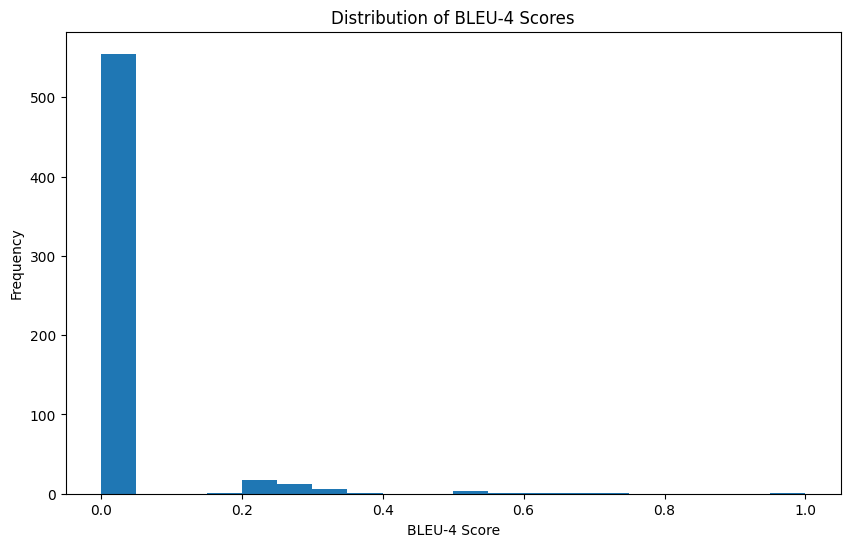

In [8]:
# Import necessary libraries
! pip install torch torchvision torchaudio nltk
import os
import random
import numpy as np
import pandas as pd
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
import matplotlib.pyplot as plt
import nltk

# Download necessary NLTK data
try:
    nltk.download('punkt')
except:
    pass

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Paths
csv_file = "/kaggle/input/3d-p-structures/pdb_voxel_mapping.csv"
feature_folder = "/kaggle/input/3d-p-structures/extracted_features/content/extracted_features"

# Check CSV format properly
def check_csv(csv_file):
    print(f"\nChecking CSV file: {csv_file}")
    if os.path.exists(csv_file):
        # First try reading with header
        df = pd.read_csv(csv_file)
        print(f"CSV shape with header: {df.shape}")
        print("First 5 rows (with header):")
        print(df.head())

        # Also try reading without header for comparison
        df_no_header = pd.read_csv(csv_file, header=None)
        print(f"\nCSV shape without header: {df_no_header.shape}")
        print("First 5 rows (without header):")
        print(df_no_header.head())

        return df
    else:
        print("CSV file does not exist!")
        return None

# Check the structure of the feature folder
def inspect_feature_folder(feature_folder):
    print(f"\nInspecting feature folder: {feature_folder}")

    if not os.path.exists(feature_folder):
        print("Feature folder does not exist!")
        return []

    all_files = os.listdir(feature_folder)
    print(f"Total files in folder: {len(all_files)}")

    # Show file extensions
    extensions = {}
    for file in all_files:
        ext = os.path.splitext(file)[1]
        extensions[ext] = extensions.get(ext, 0) + 1

    print("File extensions:")
    for ext, count in extensions.items():
        print(f"  {ext}: {count} files")

    # Show some example files
    print("\nSample files:")
    for file in all_files[:5]:
        full_path = os.path.join(feature_folder, file)
        size = os.path.getsize(full_path)
        print(f"  - {file} ({size} bytes)")

    return all_files

# Simple tokenizer
class SimpleTokenizer:
    def __init__(self, min_freq=1, max_vocab=10000):
        self.word2idx = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}
        self.idx2word = {0: '<pad>', 1: '<start>', 2: '<end>', 3: '<unk>'}
        self.min_freq = min_freq
        self.max_vocab = max_vocab
        self.counter = Counter()
        self.built = False

    def preprocess(self, text):
        # Handle non-string inputs
        if not isinstance(text, str):
            text = str(text)
        # Simple preprocessing: lowercase and split by space
        return text.lower().split()

    def update_counter(self, texts):
        for text in texts:
            tokens = self.preprocess(text)
            self.counter.update(tokens)

    def build_vocab(self):
        # Keep only frequent words
        words = [word for word, count in self.counter.items()
                 if count >= self.min_freq]

        # Limit vocabulary size
        if len(words) > self.max_vocab:
            words = sorted([(word, count) for word, count in self.counter.items()
                            if count >= self.min_freq],
                           key=lambda x: x[1], reverse=True)[:self.max_vocab]
            words = [word for word, _ in words]

        # Add words to vocabulary
        for word in words:
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word

        self.built = True

    def encode(self, text, max_length=None):
        if not self.built:
            raise ValueError("Vocabulary not built yet. Call build_vocab() first.")

        tokens = self.preprocess(text)
        token_ids = [self.word2idx.get(token, self.word2idx['<unk>']) for token in tokens]

        # Add start and end tokens
        token_ids = [self.word2idx['<start>']] + token_ids + [self.word2idx['<end>']]

        # Apply max_length if specified
        if max_length is not None:
            if len(token_ids) > max_length:
                token_ids = token_ids[:max_length]
            else:
                token_ids = token_ids + [self.word2idx['<pad>']] * (max_length - len(token_ids))

        return token_ids

    def decode(self, token_ids):
        return [self.idx2word.get(idx, '<unk>') for idx in token_ids]

    def __len__(self):
        return len(self.word2idx)

class ProteinStructureCaptioningDataset(Dataset):
    def __init__(self, csv_file, feature_folder, tokenizer, max_caption_length=50):
        self.df = pd.read_csv(csv_file)
        self.feature_folder = feature_folder
        self.tokenizer = tokenizer
        self.max_caption_length = max_caption_length
        self.voxel_to_feature = self._map_voxel_to_feature()
        self.caption_column = self._get_caption_column()
        self.voxel_column = self._get_voxel_column()

    def _get_caption_column(self):
        if 'description' in self.df.columns:
            return 'description'
        elif 1 in self.df.columns:
            return 1
        else:
            return self.df.columns[1]

    def _get_voxel_column(self):
        if 'voxel_file' in self.df.columns:
            return 'voxel_file'
        elif 0 in self.df.columns:
            return 0
        else:
            return self.df.columns[0]

    def _map_voxel_to_feature(self):
        mapping = {}
        for filename in os.listdir(self.feature_folder):
            base_name = os.path.splitext(filename)[0]
            mapping[base_name] = os.path.join(self.feature_folder, filename)
        return mapping

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        voxel_file = row[self.voxel_column]
        caption = row[self.caption_column]

        base_name = os.path.splitext(os.path.basename(voxel_file))[0]
        feature_path = self.voxel_to_feature.get(base_name)
        if feature_path and os.path.exists(feature_path):
            features = np.load(feature_path)
            # Assuming features are 2D, flatten them for simplicity as input to Transformer
            features = features.flatten()
        else:
            # Handle missing feature files appropriately
            features = np.zeros((2048,)) # Example: initialize with zeros

        token_ids = self.tokenizer.encode(caption, max_length=self.max_caption_length)
        return torch.tensor(features, dtype=torch.float32), torch.tensor(token_ids, dtype=torch.long)

def collate_fn(batch):
    features, captions = zip(*batch)
    features = torch.stack(features, 0)
    # Pad captions
    captions = pad_sequence(captions, batch_first=True, padding_value=0)
    return features, captions

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerCaptioner(nn.Module):
    def __init__(self, feature_size, embed_size, hidden_size, vocab_size, num_heads=8, num_layers=6, dropout=0.1, max_len=50):
        super(TransformerCaptioner, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.pos_encoder = PositionalEncoding(embed_size, dropout, max_len)
        decoder_layer = TransformerDecoderLayer(embed_size, num_heads, hidden_size, dropout)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers)
        self.linear = nn.Linear(embed_size, vocab_size)
        self.feature_proj = nn.Linear(feature_size, embed_size) # Project features to embedding size
        self.dropout = nn.Dropout(dropout)
        self.vocab_size = vocab_size
        self.max_len = max_len

    def forward(self, features, captions):
        # Project features and add positional encoding (treating features as a sequence of length 1)
        memory = self.dropout(self.feature_proj(features).unsqueeze(1)) # (batch_size, 1, embed_size)
        
        # Transpose memory to match transformer decoder's expected shape [seq_len, batch_size, embed_dim]
        memory = memory.transpose(0, 1)

        # Embed and add positional encoding to captions
        tgt_embeddings = self.dropout(self.embed(captions)) * torch.sqrt(torch.tensor(self.embed.embedding_dim, dtype=torch.float))
        tgt_embeddings = self.pos_encoder(tgt_embeddings)
        
        # Transpose target embeddings to match transformer decoder's expected shape [seq_len, batch_size, embed_dim]
        tgt_embeddings = tgt_embeddings.transpose(0, 1)

        # Generate the mask for the target sequence based on the current caption length
        tgt_mask = self._generate_square_subsequent_mask(tgt_embeddings.size(0)).to(captions.device)

        # Decode
        output = self.transformer_decoder(tgt_embeddings, memory, tgt_mask=tgt_mask)
        
        # Transpose output back to [batch_size, seq_len, embed_size]
        output = output.transpose(0, 1)
        
        # Apply linear projection to get logits
        output = self.linear(output)
        return output

    def generate_caption(self, features, start_token_idx, end_token_idx, max_len=50):
        """Generate caption using greedy decoding."""
        # Project features
        memory = self.dropout(self.feature_proj(features).unsqueeze(1))
        # Transpose to [seq_len, batch_size, embed_dim]
        memory = memory.transpose(0, 1)
        
        batch_size = features.size(0)
        tgt = torch.full((batch_size, 1), start_token_idx, dtype=torch.long).to(features.device)

        for i in range(max_len - 1):
            # Embed target tokens
            tgt_embeddings = self.dropout(self.embed(tgt)) * torch.sqrt(torch.tensor(self.embed.embedding_dim, dtype=torch.float))
            tgt_embeddings = self.pos_encoder(tgt_embeddings)
            
            # Transpose to [seq_len, batch_size, embed_dim]
            tgt_embeddings = tgt_embeddings.transpose(0, 1)
            
            # Generate appropriate mask
            tgt_mask = self._generate_square_subsequent_mask(tgt_embeddings.size(0)).to(tgt.device)
            
            # Pass through transformer decoder
            output = self.transformer_decoder(tgt_embeddings, memory, tgt_mask=tgt_mask)
            
            # Transpose output back to [batch_size, seq_len, embed_dim]
            output = output.transpose(0, 1)
            
            # Get next word prediction
            prob = F.softmax(self.linear(output[:, -1, :]), dim=-1)
            next_word = torch.argmax(prob, dim=-1).unsqueeze(1)
            tgt = torch.cat((tgt, next_word), dim=1)
            
            # Stop if all sequences have end token
            if (next_word == end_token_idx).all():
                break
                
        return tgt

    def _generate_square_subsequent_mask(self, sz):
        """Generate a square mask for the sequence. The masked positions are filled with float('-inf').
        Unmasked positions are filled with float(0.0).
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

def evaluate_bleu(model, dataloader, tokenizer, device, max_len=50):
    """
    Evaluate the model using BLEU score on the validation set.
    
    Args:
        model: The trained captioning model
        dataloader: DataLoader containing validation data
        tokenizer: Tokenizer used for encoding/decoding
        device: Device to run the model on
        max_len: Maximum length of generated captions
        
    Returns:
        list: BLEU scores for different n-gram weights
    """
    model.eval()
    all_references = []
    all_candidates = []
    
    start_token_idx = tokenizer.word2idx['<start>']
    end_token_idx = tokenizer.word2idx['<end>']
    pad_token_idx = tokenizer.word2idx['<pad>']
    
    with torch.no_grad():
        for features, captions in dataloader:
            features = features.to(device)
            
            # Generate captions
            generated_captions = model.generate_caption(
                features, start_token_idx, end_token_idx, max_len=max_len
            )
            
            # Process each caption in the batch
            for i, (generated, reference) in enumerate(zip(generated_captions, captions)):
                # Convert tensors to lists and remove special tokens
                candidate = [
                    tokenizer.idx2word[idx.item()] for idx in generated 
                    if idx.item() not in [start_token_idx, end_token_idx, pad_token_idx]
                ]
                
                # Get reference without special tokens
                reference_tokens = [
                    tokenizer.idx2word[idx.item()] for idx in reference 
                    if idx.item() not in [start_token_idx, end_token_idx, pad_token_idx]
                ]
                
                # Add to lists for corpus BLEU calculation
                all_references.append([reference_tokens])
                all_candidates.append(candidate)
    
    # Calculate BLEU-1, BLEU-2, BLEU-3, and BLEU-4 scores
    weights = [(1, 0, 0, 0), (0.5, 0.5, 0, 0), (0.33, 0.33, 0.33, 0), (0.25, 0.25, 0.25, 0.25)]
    bleu_scores = []
    
    for weight in weights:
        score = corpus_bleu(all_references, all_candidates, weights=weight)
        bleu_scores.append(score)
    
    return bleu_scores

def analyze_bleu_scores(model, dataloader, tokenizer, device, max_len=50, num_examples=5):
    """
    Analyze BLEU scores distribution and show examples of high and low scoring captions.
    
    Args:
        model: The trained captioning model
        dataloader: DataLoader containing validation data
        tokenizer: Tokenizer used for encoding/decoding
        device: Device to run the model on
        max_len: Maximum length of generated captions
        num_examples: Number of examples to show for high and low scores
    """
    model.eval()
    item_scores = []
    all_references = []
    all_candidates = []
    all_features = []
    
    start_token_idx = tokenizer.word2idx['<start>']
    end_token_idx = tokenizer.word2idx['<end>']
    pad_token_idx = tokenizer.word2idx['<pad>']
    
    with torch.no_grad():
        for features, captions in dataloader:
            features = features.to(device)
            
            # Generate captions
            generated_captions = model.generate_caption(
                features, start_token_idx, end_token_idx, max_len=max_len
            )
            
            # Process each caption in the batch
            for i, (feature, generated, reference) in enumerate(zip(features, generated_captions, captions)):
                # Convert tensors to lists and remove special tokens
                candidate = [
                    tokenizer.idx2word[idx.item()] for idx in generated 
                    if idx.item() not in [start_token_idx, end_token_idx, pad_token_idx]
                ]
                
                # Get reference without special tokens
                reference_tokens = [
                    tokenizer.idx2word[idx.item()] for idx in reference 
                    if idx.item() not in [start_token_idx, end_token_idx, pad_token_idx]
                ]
                
                # Calculate BLEU-4 score for this example
                bleu4_score = sentence_bleu([reference_tokens], candidate, 
                                           weights=(0.25, 0.25, 0.25, 0.25))
                
                item_scores.append(bleu4_score)
                all_references.append(reference_tokens)
                all_candidates.append(candidate)
                all_features.append(feature.cpu())
    
    # Plot histogram of BLEU scores
    plt.figure(figsize=(10, 6))
    plt.hist(item_scores, bins=20)
    plt.title('Distribution of BLEU-4 Scores')
    plt.xlabel('BLEU-4 Score')
    plt.ylabel('Frequency')
    plt.savefig('bleu_score_distribution.png')
    
    # Find examples with highest and lowest scores
    scores_with_idx = [(score, idx) for idx, score in enumerate(item_scores)]
    highest_scores = sorted(scores_with_idx, reverse=True)[:num_examples]
    lowest_scores = sorted(scores_with_idx)[:num_examples]
    
    print("\n=== Examples with Highest BLEU-4 Scores ===")
    for score, idx in highest_scores:
        print(f"BLEU-4 Score: {score:.4f}")
        print(f"Reference: {' '.join(all_references[idx])}")
        print(f"Generated: {' '.join(all_candidates[idx])}")
        print("---")
    
    print("\n=== Examples with Lowest BLEU-4 Scores ===")
    for score, idx in lowest_scores:
        print(f"BLEU-4 Score: {score:.4f}")
        print(f"Reference: {' '.join(all_references[idx])}")
        print(f"Generated: {' '.join(all_candidates[idx])}")
        print("---")
    
    # Calculate average BLEU score
    avg_bleu4 = sum(item_scores) / len(item_scores)
    print(f"\nAverage BLEU-4 Score: {avg_bleu4:.4f}")

# Main execution block
try:
    # Check CSV file
    df = check_csv(csv_file)

    # Inspect feature folder
    feature_files = inspect_feature_folder(feature_folder)

    if df is not None and len(feature_files) > 0:
        # Determine caption column
        if 'description' in df.columns:
            caption_column = 'description'
        elif 1 in df.columns:
            caption_column = 1
        else:
            caption_column = df.columns[1]

        # Build vocabulary
        tokenizer = SimpleTokenizer()
        tokenizer.update_counter(df[caption_column].astype(str).tolist())
        tokenizer.build_vocab()
        print(f"\nVocabulary size: {len(tokenizer)}")

        # Create Dataset and split into train/validation
        max_caption_length = 50
        dataset = ProteinStructureCaptioningDataset(csv_file, feature_folder, tokenizer, max_caption_length)
        
        # Split dataset into train and validation sets
        dataset_size = len(dataset)
        train_size = int(dataset_size * 0.8)
        val_size = dataset_size - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
        val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

        # Model parameters
        feature_size = dataset[0][0].shape[0] # Get feature size from the first item
        embed_size = 256
        hidden_size = 512
        vocab_size = len(tokenizer)
        num_heads = 8
        num_layers = 3
        dropout = 0.1
        max_len = max_caption_length

        # Instantiate the Transformer model
        model = TransformerCaptioner(feature_size, embed_size, hidden_size, vocab_size, num_heads, num_layers, dropout, max_len)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word2idx['<pad>'])
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Training loop
        num_epochs = 50
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        for epoch in range(num_epochs):
            # Training phase
            model.train()
            total_loss = 0
            for batch_idx, (features, captions) in enumerate(train_dataloader):
                features = features.to(device)
                captions = captions.to(device)

                optimizer.zero_grad()
                outputs = model(features, captions[:, :-1])  # Exclude <end> token for input
                targets = captions[:, 1:]  # Exclude <start> token for target
                
                # Reshape outputs and targets for loss calculation
                outputs = outputs.reshape(-1, vocab_size)
                targets = targets.reshape(-1)

                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                if (batch_idx + 1) % 10 == 0:
                    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

            avg_loss = total_loss / len(train_dataloader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')
            
            # Evaluate with BLEU score
            bleu_scores = evaluate_bleu(model, val_dataloader, tokenizer, device, max_len=max_caption_length)
            print(f'BLEU-1: {bleu_scores[0]:.4f}, BLEU-2: {bleu_scores[1]:.4f}, BLEU-3: {bleu_scores[2]:.4f}, BLEU-4: {bleu_scores[3]:.4f}')

        # After training, analyze BLEU scores in detail
        analyze_bleu_scores(model, val_dataloader, tokenizer, device, max_len=max_caption_length)

        # Example of generating a caption for the first item in the dataset
        model.eval()
        with torch.no_grad():
            first_feature = dataset[0][0].unsqueeze(0).to(device)
            start_token_idx = tokenizer.word2idx['<start>']
            end_token_idx = tokenizer.word2idx['<end>']
            generated_tokens = model.generate_caption(first_feature, start_token_idx, end_token_idx, max_len=max_caption_length)[0].cpu().numpy()
            generated_caption = tokenizer.decode([token for token in generated_tokens if token not in [tokenizer.word2idx['<start>'], tokenizer.word2idx['<end>'], tokenizer.word2idx['<pad>']]])
            print("\nGenerated Caption (Example):", " ".join(generated_caption))

except Exception as e:
    print(f"Error occurred: {str(e)}")
    import traceback
    traceback.print_exc()
